In [2]:
%matplotlib inline
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import prophet

import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import numpy as np
import datetime
import requests
import warnings

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm

warnings.filterwarnings('ignore')

In [58]:
def MASE(Actual, Predicted):
    n = len(Actual)
    
    mae = mean_absolute_error(Actual, Predicted)

    # Calculate the denominator
    denominator = (1 / (n - 1)) * np.sum(np.abs(Actual.values[1:] - Actual.values[:-1]))

    # Avoid division by zero or small denominators
    if denominator > 1e-6:
        mase = mae / denominator
    else:
        mase = np.inf

    return mase

In [5]:
all_features = pd.read_csv('data/multivar_data/finaldataall.csv', parse_dates = [0])
selected_features = pd.read_csv('data/multivar_data/finaldata_selectedfeatures.csv', parse_dates = [0])

In [6]:
all_features.columns.tolist()

['date',
 'location',
 'year',
 'mmwr_week',
 'covid_19_deaths',
 'distributed',
 'distributed_janssen',
 'distributed_moderna',
 'distributed_pfizer',
 'distributed_novavax',
 'distributed_unk_manuf',
 'dist_per_100k',
 'distributed_per_100k_5plus',
 'distributed_per_100k_12plus',
 'distributed_per_100k_18plus',
 'distributed_per_100k_65plus',
 'administered',
 'administered_5plus',
 'administered_12plus',
 'administered_18plus',
 'administered_65plus',
 'administered_janssen',
 'administered_moderna',
 'administered_pfizer',
 'administered_novavax',
 'administered_unk_manuf',
 'admin_per_100k',
 'admin_per_100k_5plus',
 'admin_per_100k_12plus',
 'admin_per_100k_18plus',
 'admin_per_100k_65plus',
 'recip_administered',
 'administered_dose1_recip',
 'administered_dose1_pop_pct',
 'administered_dose1_recip_5plus',
 'administered_dose1_recip_5plus_pop_pct',
 'administered_dose1_recip_12plus',
 'administered_dose1_recip_12plus_pop_pct',
 'administered_dose1_recip_18plus',
 'administered_d

In [326]:
multi_prophet = all_features

#multi_prophet = multi_prophet.rename(columns={'date': 'ds', 'covid_19_deaths': 'y'})

multi_prophet = multi_prophet.drop(['region_Puerto_Rico','location','year','month','deaths_1_year_lag','deaths_1_andhalf_year_lag', 'deaths_2_years_lag',
       'deaths_half_year_lag_mean', 'deaths_1_year_lag_mean',
       'deaths_1_andhalf_year_lag_mean', 'deaths_2_years_lag_mean',
       'deaths_half_year_lag_std', 'deaths_1_year_lag_std',
       'deaths_1_andhalf_year_lag_std', 'deaths_2_years_lag_std','deaths_half_year_lag_max', 'deaths_1_year_lag_max',
       'deaths_1_andhalf_year_lag_max', 'deaths_2_years_lag_max',
       'deaths_half_year_lag_min', 'deaths_1_year_lag_min',
       'deaths_1_andhalf_year_lag_min', 'deaths_2_years_lag_min', 'date.1',
       'dayofweek', 'quarter', 'dayofyear', 'dayofmonth', 'weekofyear', 'holidays_Holiday',
       'holidays_Normal_day', 'month_sin', 'month_cos', 'dayofweek_sin',
       'dayofweek_cos', 'season_Fall', 'season_Spring', 'season_Summer', 'season_Winter',
       'deaths_half_year_lag', 'mmwr_week'], axis=1)

In [327]:
multi_prophet.fillna(-1000000, inplace = True)
multi_prophet['date'] = pd.to_datetime(multi_prophet['date'])

In [329]:
multi_prophet.set_index('date', inplace=True)

start_date = '2020-01-04'
end_date = '2023-02-25'
train_end_date = '2022-12-31'

In [330]:
# Train test split
train = multi_prophet[multi_prophet.index <= train_end_date]
test = multi_prophet[multi_prophet.index > train_end_date]

# Check the shape of the dataset
print(train.shape)
print(test.shape)

(6974, 104)
(332, 104)


In [331]:
train['log_deaths'] = np.log1p(train['covid_19_deaths'])
test['log_deaths'] = np.log1p(test['covid_19_deaths'])

# Baseline Model

12:36:40 - cmdstanpy - INFO - Chain [1] start processing
12:36:43 - cmdstanpy - INFO - Chain [1] done processing


The MAE for the baseline model is 43.83141972500174
The MASE for the baseline model is 0.717517306081878


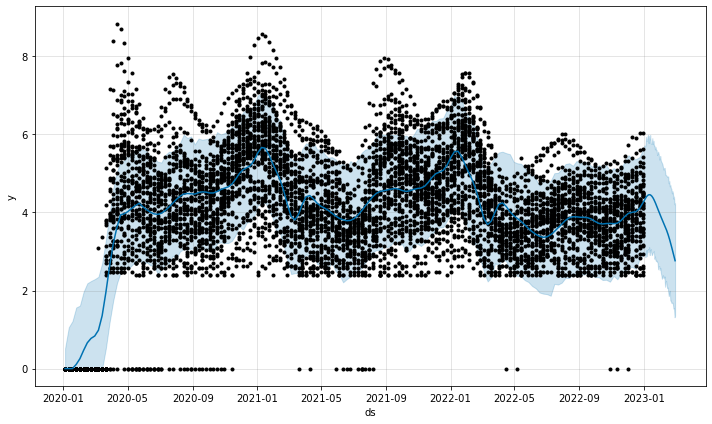

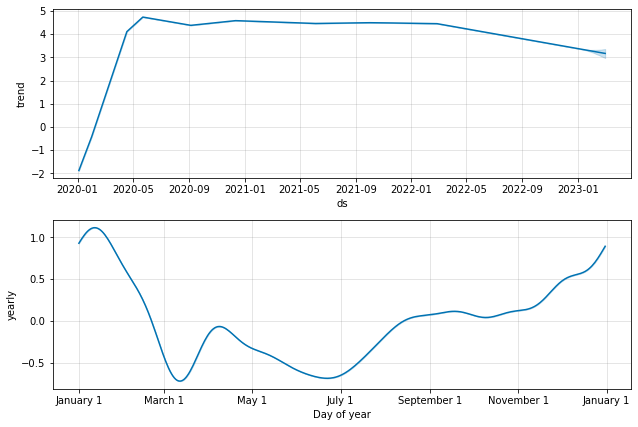

In [85]:
# Use the default hyperparameters to initiate the Prophet model
model_baseline = prophet.Prophet()

# Fit the model on the training dataset
model_baseline.fit(train.reset_index().rename(columns={'date':'ds', 'log_deaths':'y'}))

# 30 day forecase
future_baseline = model_baseline.make_future_dataframe(periods=60)

# Make prediction
forecast_baseline = model_baseline.predict(future_baseline)
for col in ['yhat', 'yhat_lower', 'yhat_upper']:
    forecast_baseline[col] = forecast_baseline[col].clip(lower=0.0)

# Visualize the forecast
model_baseline.plot(forecast_baseline); # Add semi-colon to remove the duplicated chart

# Visualize the forecast components
model_baseline.plot_components(forecast_baseline);

# Merge actual and predicted values
performance_baseline = pd.merge(test.reset_index().rename(columns={'date':'ds', 'covid_19_deaths':'y'}), forecast_baseline[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-60:], on='ds')
performance_baseline['yhat'] = np.expm1(performance_baseline['yhat'])

# Check MAE value
performance_baseline_MAE = mean_absolute_error(performance_baseline['y'], performance_baseline['yhat'])
print(f'The MAE for the baseline model is {performance_baseline_MAE}')

# Check MAPE value
performance_baseline_MASE = MASE(performance_baseline['y'], performance_baseline['yhat'])
print(f'The MASE for the baseline model is {performance_baseline_MASE}')

# Changepoints

In [72]:
# Default change points
train2 = train.reset_index().rename(columns={'date':'ds', 'log_deaths':'y'})
print(f'There are {len(model_baseline.changepoints)} change points. \nThe change points dates are \n{train2.loc[train2["ds"].isin(model_baseline.changepoints)]}')

There are 25 change points. 
The change points dates are 
             ds  covid_19_deaths  distributed  distributed_janssen  \
198  2020-02-01              0.0          0.0                  0.0   
199  2020-02-01              0.0          0.0                  0.0   
200  2020-02-01              0.0          0.0                  0.0   
201  2020-02-01              0.0          0.0                  0.0   
202  2020-02-01              0.0          0.0                  0.0   
...         ...              ...          ...                  ...   
5595 2022-05-14             15.0    8310750.0             325200.0   
5596 2022-05-14             10.0    6000410.0             259200.0   
5597 2022-05-14             34.0   13562480.0             609400.0   
5598 2022-05-14             60.0   17136710.0             619000.0   
5599 2022-05-14             24.0   11737705.0             429000.0   

      distributed_moderna  distributed_pfizer  distributed_novavax  \
198                   0.0      

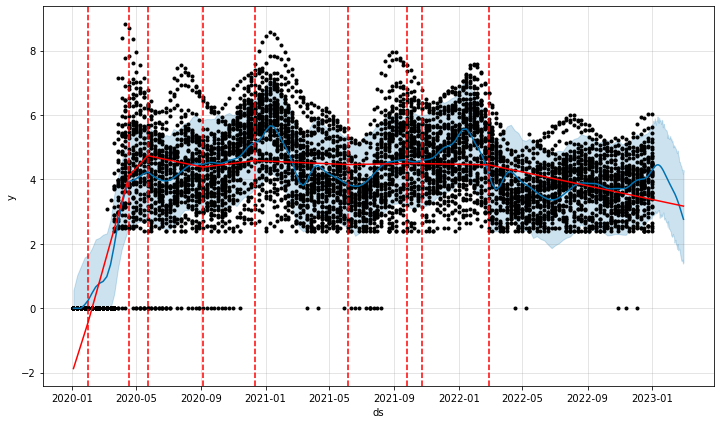

In [73]:
from prophet.plot import add_changepoints_to_plot

# Change points to plot
fig = model_baseline.plot(forecast_baseline)
a = add_changepoints_to_plot(fig.gca(), model_baseline, forecast_baseline)

(0.0, 2000.0)

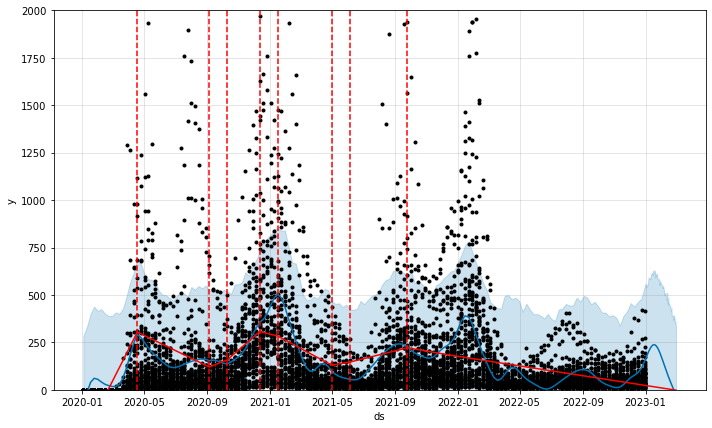

In [40]:
# Zoomed in plot
fig = model_baseline.plot(forecast_baseline)
a = add_changepoints_to_plot(fig.gca(), model_baseline, forecast_baseline)
ax = plt.gca()
ax.set_ylim([0, 2000])

12:41:45 - cmdstanpy - INFO - Chain [1] start processing
12:41:46 - cmdstanpy - INFO - Chain [1] done processing
12:41:46 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:41:47 - cmdstanpy - INFO - Chain [1] start processing
12:41:56 - cmdstanpy - INFO - Chain [1] done processing


The MAE for the baseline model is 43.10878990146549
The MASE for the baseline model is 0.7056879059043065


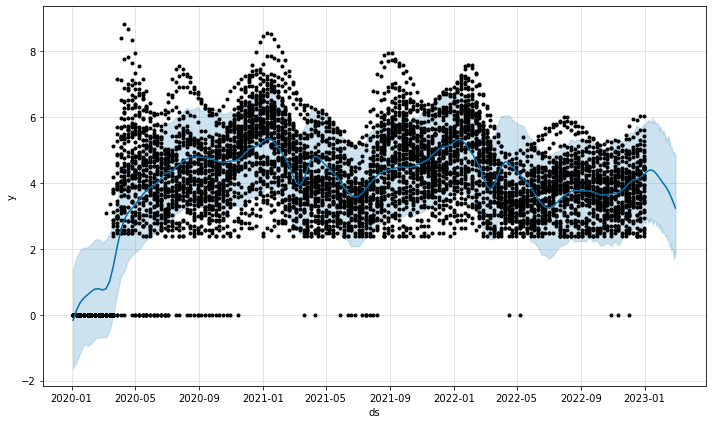

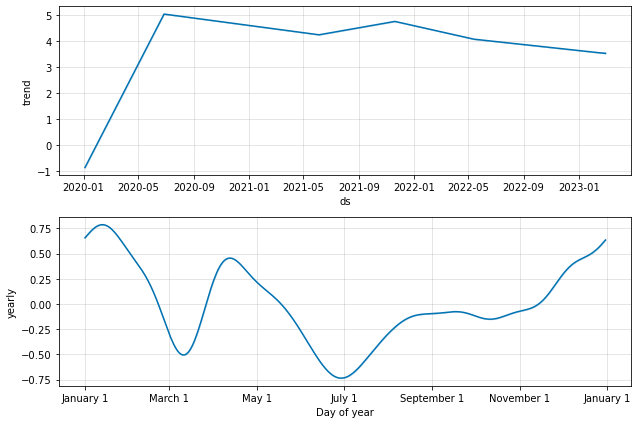

In [97]:
# Create the prophet model with confidence internal of 95%
model_changepoint = prophet.Prophet(n_changepoints=5)
# Fit the model using the training dataset
model_changepoint.fit(train.reset_index().rename(columns={'date':'ds', 'log_deaths':'y'}))

# Create the time range for the forecast
future_changepoint = model_changepoint.make_future_dataframe(periods=60)

# Make prediction
forecast_changepoint = model_changepoint.predict(future_changepoint)

# Visualize the forecast
model_changepoint.plot(forecast_changepoint); # Add semi-colon to remove the duplicated chart

# Visualize the forecast components
model_changepoint.plot_components(forecast_changepoint);

# Merge actual and predicted values
performance_changepoint = pd.merge(test.reset_index().rename(columns={'date':'ds', 'covid_19_deaths':'y'}),
                                   forecast_changepoint[['ds', 'yhat', 'yhat_lower', 'yhat_upper']],
                                   on='ds')
performance_changepoint['yhat'] = np.expm1(performance_changepoint['yhat'])

# Check MAE value
performance_changepoint_MAE = mean_absolute_error(performance_changepoint['y'], performance_changepoint['yhat'])
print(f'The MAE for the baseline model is {performance_changepoint_MAE}')

# Check MAPE value
performance_changepoint_MASE = MASE(performance_changepoint['y'], performance_changepoint['yhat'])
print(f'The MASE for the baseline model is {performance_changepoint_MASE}')

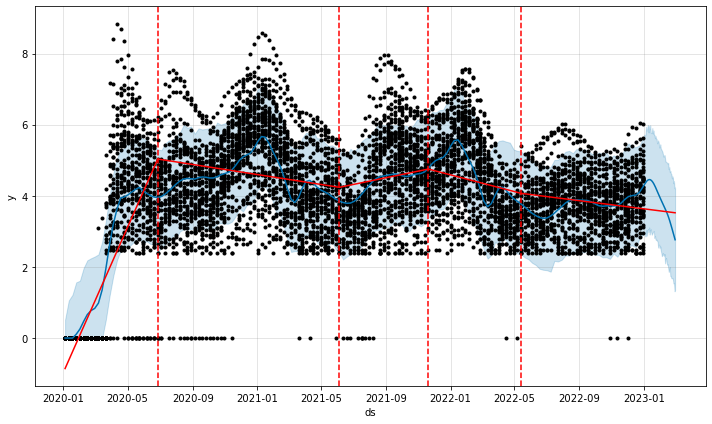

In [89]:
# Change points to plot
fig = model_changepoint.plot(forecast_changepoint)
a = add_changepoints_to_plot(fig.gca(), model_changepoint, forecast_changepoint)

## reduce changpoints (overfitting)

12:42:37 - cmdstanpy - INFO - Chain [1] start processing
12:42:37 - cmdstanpy - INFO - Chain [1] done processing


The MAE for the baseline model is 44.2069617154945
The MASE for the baseline model is 0.7236649024643264


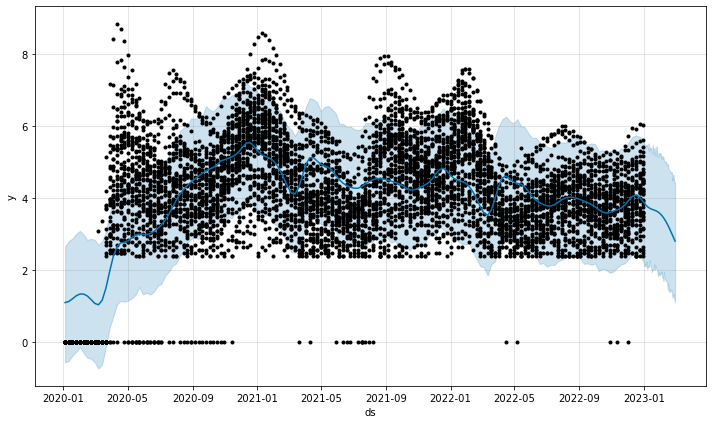

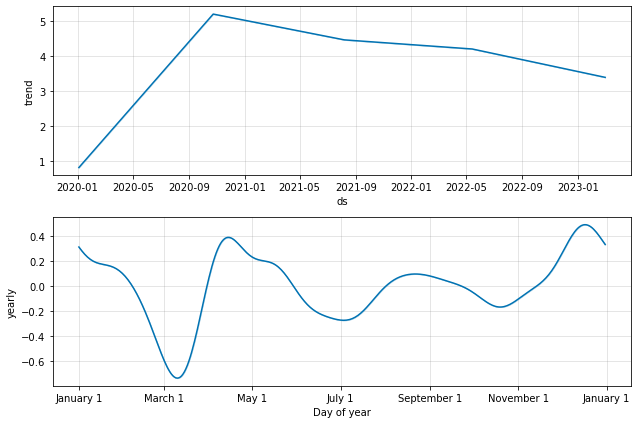

In [99]:
# Create the prophet model with confidence internal of 95%
model_changepoint = prophet.Prophet(n_changepoints=3)
# Fit the model using the training dataset
model_changepoint.fit(train.reset_index().rename(columns={'date':'ds', 'log_deaths':'y'}))

# Create the time range for the forecast
future_changepoint = model_changepoint.make_future_dataframe(periods=60)

# Make prediction
forecast_changepoint = model_changepoint.predict(future_changepoint)

# Visualize the forecast
model_changepoint.plot(forecast_changepoint); # Add semi-colon to remove the duplicated chart

# Visualize the forecast components
model_changepoint.plot_components(forecast_changepoint);

# Merge actual and predicted values
performance_changepoint = pd.merge(test.reset_index().rename(columns={'date':'ds', 'covid_19_deaths':'y'}),
                                   forecast_changepoint[['ds', 'yhat', 'yhat_lower', 'yhat_upper']],
                                   on='ds')
performance_changepoint['yhat'] = np.expm1(performance_changepoint['yhat'])

# Check MAE value
performance_changepoint_MAE = mean_absolute_error(performance_changepoint['y'], performance_changepoint['yhat'])
print(f'The MAE for the baseline model is {performance_changepoint_MAE}')

# Check MAPE value
performance_changepoint_MASE = MASE(performance_changepoint['y'], performance_changepoint['yhat'])
print(f'The MASE for the baseline model is {performance_changepoint_MASE}')

# Add Holidays

12:50:08 - cmdstanpy - INFO - Chain [1] start processing
12:50:08 - cmdstanpy - INFO - Chain [1] done processing


The MAE for the baseline model is 43.68971595024983
The MASE for the baseline model is 0.7151976251005288


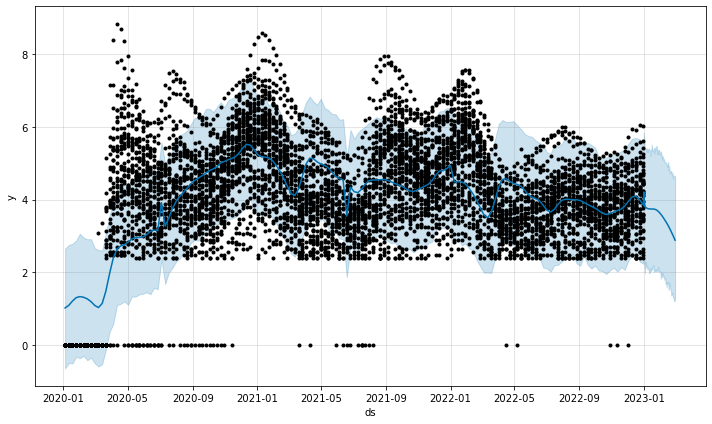

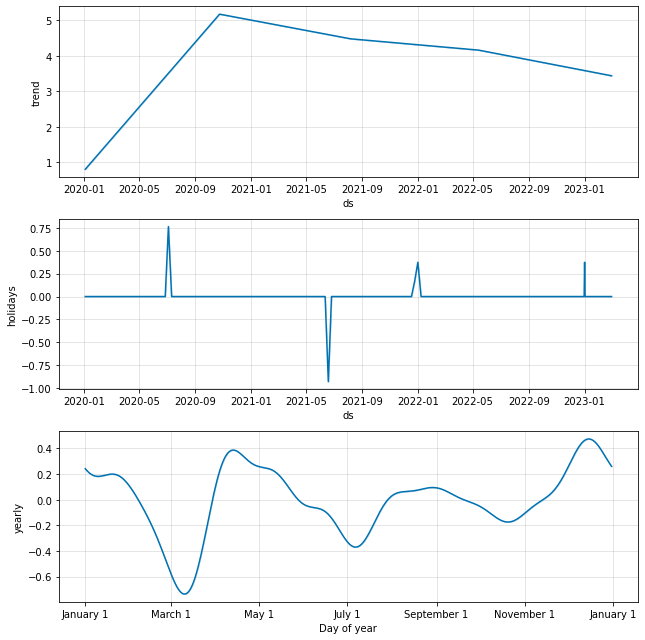

In [115]:
# Create the prophet model with confidence internal of 95%
model_changepoint = prophet.Prophet(n_changepoints=3)
model_changepoint.add_country_holidays(country_name='US')

# Fit the model using the training dataset
model_changepoint.fit(train.reset_index().rename(columns={'date':'ds', 'log_deaths':'y'}))

# Create the time range for the forecast
future_changepoint = model_changepoint.make_future_dataframe(periods=60)

# Make prediction
forecast_changepoint = model_changepoint.predict(future_changepoint)

# Visualize the forecast
model_changepoint.plot(forecast_changepoint); # Add semi-colon to remove the duplicated chart

# Visualize the forecast components
model_changepoint.plot_components(forecast_changepoint);

# Merge actual and predicted values
performance_changepoint = pd.merge(test.reset_index().rename(columns={'date':'ds', 'covid_19_deaths':'y'}),
                                   forecast_changepoint[['ds', 'yhat', 'yhat_lower', 'yhat_upper']],
                                   on='ds')
performance_changepoint['yhat'] = np.expm1(performance_changepoint['yhat'])

# Check MAE value
performance_changepoint_MAE = mean_absolute_error(performance_changepoint['y'], performance_changepoint['yhat'])
print(f'The MAE for the baseline model is {performance_changepoint_MAE}')

# Check MAPE value
performance_changepoint_MASE = MASE(performance_changepoint['y'], performance_changepoint['yhat'])
print(f'The MASE for the baseline model is {performance_changepoint_MASE}')

# Add Seasonality

12:50:51 - cmdstanpy - INFO - Chain [1] start processing
12:50:51 - cmdstanpy - INFO - Chain [1] done processing


The MAE for the baseline model is 43.65610736023615
The MASE for the baseline model is 0.7146474548090092


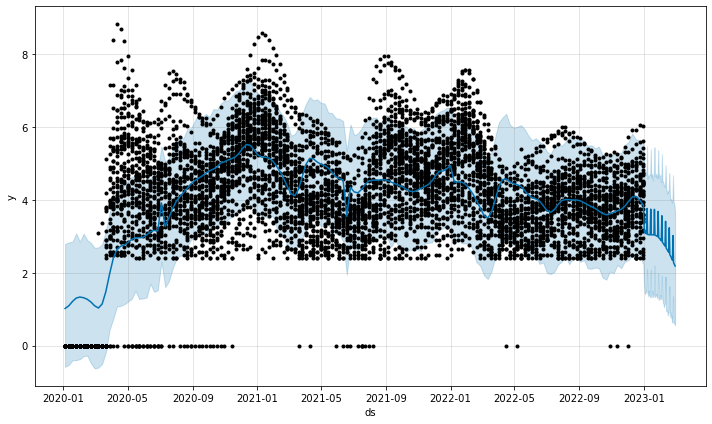

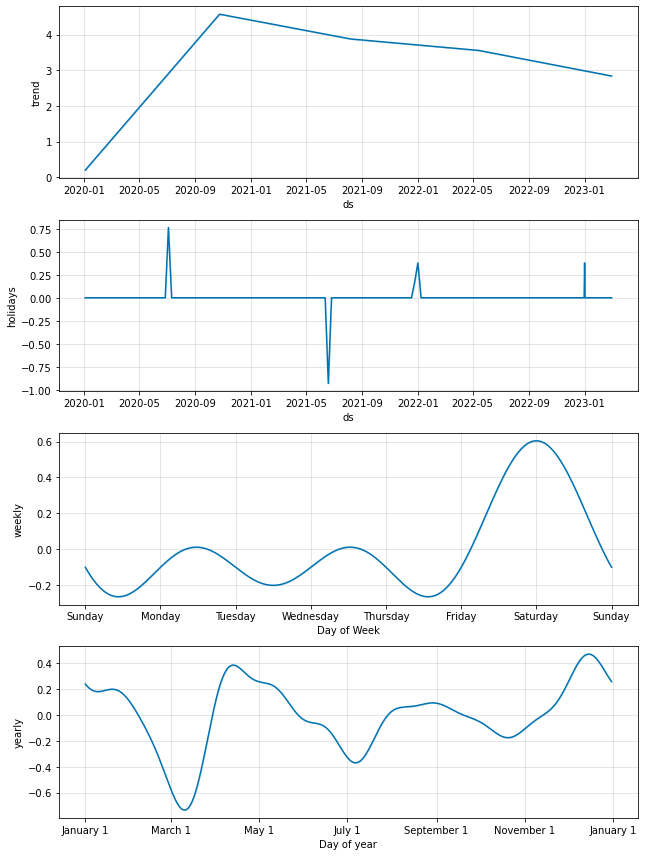

In [116]:
# Create the prophet model with confidence internal of 95%
model_changepoint = prophet.Prophet(n_changepoints=3, yearly_seasonality = True, weekly_seasonality = True)
model_changepoint.add_country_holidays(country_name='US')

# Fit the model using the training dataset
model_changepoint.fit(train.reset_index().rename(columns={'date':'ds', 'log_deaths':'y'}))

# Create the time range for the forecast
future_changepoint = model_changepoint.make_future_dataframe(periods=60)

# Make prediction
forecast_changepoint = model_changepoint.predict(future_changepoint)

# Visualize the forecast
model_changepoint.plot(forecast_changepoint); # Add semi-colon to remove the duplicated chart

# Visualize the forecast components
model_changepoint.plot_components(forecast_changepoint);

# Merge actual and predicted values
performance_changepoint = pd.merge(test.reset_index().rename(columns={'date':'ds', 'covid_19_deaths':'y'}),
                                   forecast_changepoint[['ds', 'yhat', 'yhat_lower', 'yhat_upper']],
                                   on='ds')
performance_changepoint['yhat'] = np.expm1(performance_changepoint['yhat'])

# Check MAE value
performance_changepoint_MAE = mean_absolute_error(performance_changepoint['y'], performance_changepoint['yhat'])
print(f'The MAE for the baseline model is {performance_changepoint_MAE}')

# Check MAPE value
performance_changepoint_MASE = MASE(performance_changepoint['y'], performance_changepoint['yhat'])
print(f'The MASE for the baseline model is {performance_changepoint_MASE}')

# Add regressors

In [367]:
# Set the correlation threshold
correlation_threshold = 0.15

# Create a correlation matrix
correlation_matrix = multi_prophet.corr()

# Extract the correlations with the target variable above the threshold
correlations_above_threshold = correlation_matrix['covid_19_deaths'][correlation_matrix['covid_19_deaths'].abs() > correlation_threshold]

# Sort the correlations in descending order
correlated_list = list(correlations_above_threshold.index)
correlated_list.remove('covid_19_deaths')

In [368]:
correlated_list

['distributed_janssen',
 'administered_dose1_recip',
 'administered_dose1_recip_12plus',
 'administered_dose1_recip_18plus',
 'series_complete_18plus',
 'additional_doses_12plus_vax_pct',
 'second_booster_janssen',
 'second_booster_unk_manuf']

In [369]:
model = prophet.Prophet(n_changepoints = 3, yearly_seasonality = True, weekly_seasonality = True)
model.add_country_holidays(country_name='US')

for reg in correlated_list:
    model.add_regressor(reg)
        
model=model.fit(train.reset_index().rename(columns={'date':'ds', 'log_deaths':'y'}))

16:27:41 - cmdstanpy - INFO - Chain [1] start processing
16:27:42 - cmdstanpy - INFO - Chain [1] done processing


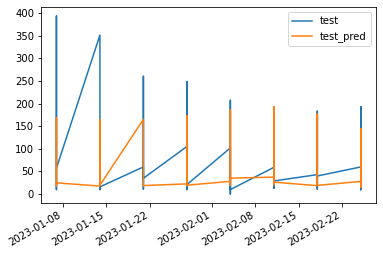


Testing Set Metrics:
Testing MAE: 49.97244248606367
Testing MASE: 0.8180454234860076


In [371]:
test_pred = model.predict(test.reset_index().rename(columns={'date': 'ds', 'log_weekly_deaths': 'y'})).set_index('ds')
test_pred = test_pred * 0.8
test_pred['yhat'] = np.expm1(test_pred['yhat'])
pd.concat([test['covid_19_deaths'],test_pred['yhat']], axis=1).plot()
plt.legend(['test', 'test_pred'])
plt.show()

# Test
test_mae = mean_absolute_error(test['covid_19_deaths'], test_pred['yhat'])
test_mase = MASE(test['covid_19_deaths'], test_pred['yhat'])

print("\nTesting Set Metrics:")
print("Testing MAE:", test_mae)
print("Testing MASE:", test_mase)

In [372]:
model = prophet.Prophet(n_changepoints = 3, yearly_seasonality = False, weekly_seasonality = True)
model.add_country_holidays(country_name='US')

for reg in correlated_list:
    model.add_regressor(reg)
        
model=model.fit(train.reset_index().rename(columns={'date':'ds', 'log_deaths':'y'}))

16:27:54 - cmdstanpy - INFO - Chain [1] start processing
16:27:55 - cmdstanpy - INFO - Chain [1] done processing


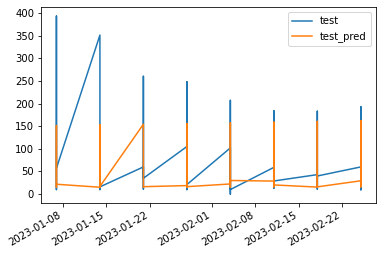


Testing Set Metrics:
Testing MAE: 51.31918907923118
Testing MASE: 0.8400915719696103


In [373]:
test_pred = model.predict(test.reset_index().rename(columns={'date': 'ds', 'log_weekly_deaths': 'y'})).set_index('ds')
test_pred = test_pred * 0.8
test_pred['yhat'] = np.expm1(test_pred['yhat'])

pd.concat([test['covid_19_deaths'],test_pred['yhat']], axis=1).plot()
plt.legend(['test', 'test_pred'])
plt.show()

# Test
test_mae = mean_absolute_error(test['covid_19_deaths'], test_pred['yhat'])
test_mase = MASE(test['covid_19_deaths'], test_pred['yhat'])

print("\nTesting Set Metrics:")
print("Testing MAE:", test_mae)
print("Testing MASE:", test_mase)

In [374]:
model = prophet.Prophet(n_changepoints = 3, yearly_seasonality = True, weekly_seasonality = True)
for col in train.columns:
    if col not in ['date', 'covid_19_deaths', 'log_deaths']:
        model.add_regressor(col)
        
model.add_country_holidays(country_name='US')
model=model.fit(train.reset_index().rename(columns={'date':'ds', 'log_deaths':'y'}))

16:28:23 - cmdstanpy - INFO - Chain [1] start processing
16:28:24 - cmdstanpy - INFO - Chain [1] done processing
16:28:24 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:28:26 - cmdstanpy - INFO - Chain [1] start processing
16:38:36 - cmdstanpy - INFO - Chain [1] done processing


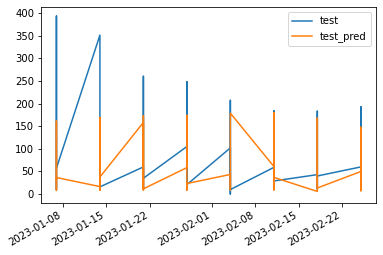


Testing Set Metrics:
Testing MAE: 52.11855670130317
Testing MASE: 0.8531771645960113


In [376]:
test_pred=model.predict(test.reset_index().rename(columns={'date':'ds', 'log_deaths':'y'})).set_index('ds')
test_pred['yhat'] = test_pred['yhat'] * 0.8
test_pred['yhat'] = np.expm1(test_pred['yhat'])
pd.concat([test['covid_19_deaths'],test_pred['yhat']], axis=1).plot( )
plt.legend(['test', 'test_pred'])
plt.show()

test_mae = mean_absolute_error(test['covid_19_deaths'], test_pred['yhat'])
test_mase = MASE(test['covid_19_deaths'], test_pred['yhat'])

print("\nTesting Set Metrics:")
print("Testing MAE:", test_mae)
print("Testing MASE:", test_mase)

# Cross Val

In [236]:
# Python
import itertools
import numpy as np
import pandas as pd
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'holidays_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'seasonality_mode': ['additive', 'multiplicative'],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
maes = []  

# Use cross validation to evaluate all parameters
for params in all_params:
    m = prophet.Prophet(**params).fit(train.reset_index().rename(columns={'date': 'ds', 'log_deaths': 'y'}))  # Fit model with given params
    df_cv = cross_validation(m, initial='720 days', period='20 days', horizon = '30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    maes.append(df_p['mae'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['mae'] = maes
print(tuning_results)

13:38:29 - cmdstanpy - INFO - Chain [1] start processing
13:38:29 - cmdstanpy - INFO - Chain [1] done processing
13:38:48 - cmdstanpy - INFO - Chain [1] start processing
13:38:48 - cmdstanpy - INFO - Chain [1] start processing
13:38:48 - cmdstanpy - INFO - Chain [1] start processing
13:38:48 - cmdstanpy - INFO - Chain [1] start processing
13:38:50 - cmdstanpy - INFO - Chain [1] done processing
13:38:50 - cmdstanpy - INFO - Chain [1] done processing
13:38:51 - cmdstanpy - INFO - Chain [1] done processing
13:38:51 - cmdstanpy - INFO - Chain [1] done processing
13:38:52 - cmdstanpy - INFO - Chain [1] start processing
13:38:52 - cmdstanpy - INFO - Chain [1] start processing
13:38:53 - cmdstanpy - INFO - Chain [1] done processing
13:38:53 - cmdstanpy - INFO - Chain [1] done processing
13:38:53 - cmdstanpy - INFO - Chain [1] start processing
13:38:54 - cmdstanpy - INFO - Chain [1] start processing
13:38:55 - cmdstanpy - INFO - Chain [1] done processing
13:38:55 - cmdstanpy - INFO - Chain [1]

13:40:34 - cmdstanpy - INFO - Chain [1] start processing
13:40:34 - cmdstanpy - INFO - Chain [1] start processing
13:40:35 - cmdstanpy - INFO - Chain [1] done processing
13:40:36 - cmdstanpy - INFO - Chain [1] done processing
13:40:36 - cmdstanpy - INFO - Chain [1] start processing
13:40:36 - cmdstanpy - INFO - Chain [1] done processing
13:40:37 - cmdstanpy - INFO - Chain [1] done processing
13:40:39 - cmdstanpy - INFO - Chain [1] start processing
13:40:40 - cmdstanpy - INFO - Chain [1] done processing
13:40:53 - cmdstanpy - INFO - Chain [1] start processing
13:40:53 - cmdstanpy - INFO - Chain [1] start processing
13:40:53 - cmdstanpy - INFO - Chain [1] start processing
13:40:53 - cmdstanpy - INFO - Chain [1] start processing
13:40:54 - cmdstanpy - INFO - Chain [1] done processing
13:40:54 - cmdstanpy - INFO - Chain [1] done processing
13:40:55 - cmdstanpy - INFO - Chain [1] done processing
13:40:56 - cmdstanpy - INFO - Chain [1] done processing
13:40:56 - cmdstanpy - INFO - Chain [1] 

13:42:54 - cmdstanpy - INFO - Chain [1] start processing
13:42:54 - cmdstanpy - INFO - Chain [1] start processing
13:42:55 - cmdstanpy - INFO - Chain [1] done processing
13:42:56 - cmdstanpy - INFO - Chain [1] done processing
13:42:56 - cmdstanpy - INFO - Chain [1] start processing
13:42:56 - cmdstanpy - INFO - Chain [1] done processing
13:42:58 - cmdstanpy - INFO - Chain [1] done processing
13:42:59 - cmdstanpy - INFO - Chain [1] start processing
13:42:59 - cmdstanpy - INFO - Chain [1] start processing
13:42:59 - cmdstanpy - INFO - Chain [1] start processing
13:43:00 - cmdstanpy - INFO - Chain [1] done processing
13:43:00 - cmdstanpy - INFO - Chain [1] done processing
13:43:01 - cmdstanpy - INFO - Chain [1] done processing
13:43:02 - cmdstanpy - INFO - Chain [1] start processing
13:43:03 - cmdstanpy - INFO - Chain [1] done processing
13:43:18 - cmdstanpy - INFO - Chain [1] start processing
13:43:18 - cmdstanpy - INFO - Chain [1] start processing
13:43:18 - cmdstanpy - INFO - Chain [1]

13:45:18 - cmdstanpy - INFO - Chain [1] start processing
13:45:19 - cmdstanpy - INFO - Chain [1] start processing
13:45:19 - cmdstanpy - INFO - Chain [1] done processing
13:45:20 - cmdstanpy - INFO - Chain [1] start processing
13:45:21 - cmdstanpy - INFO - Chain [1] done processing
13:45:21 - cmdstanpy - INFO - Chain [1] done processing
13:45:23 - cmdstanpy - INFO - Chain [1] done processing
13:45:23 - cmdstanpy - INFO - Chain [1] start processing
13:45:24 - cmdstanpy - INFO - Chain [1] start processing
13:45:24 - cmdstanpy - INFO - Chain [1] start processing
13:45:25 - cmdstanpy - INFO - Chain [1] start processing
13:45:26 - cmdstanpy - INFO - Chain [1] done processing
13:45:27 - cmdstanpy - INFO - Chain [1] done processing
13:45:27 - cmdstanpy - INFO - Chain [1] done processing
13:45:28 - cmdstanpy - INFO - Chain [1] done processing
13:45:28 - cmdstanpy - INFO - Chain [1] start processing
13:45:28 - cmdstanpy - INFO - Chain [1] start processing
13:45:29 - cmdstanpy - INFO - Chain [1]

13:47:07 - cmdstanpy - INFO - Chain [1] start processing
13:47:07 - cmdstanpy - INFO - Chain [1] start processing
13:47:08 - cmdstanpy - INFO - Chain [1] done processing
13:47:08 - cmdstanpy - INFO - Chain [1] done processing
13:47:08 - cmdstanpy - INFO - Chain [1] done processing
13:47:09 - cmdstanpy - INFO - Chain [1] done processing
13:47:10 - cmdstanpy - INFO - Chain [1] start processing
13:47:10 - cmdstanpy - INFO - Chain [1] start processing
13:47:10 - cmdstanpy - INFO - Chain [1] start processing
13:47:11 - cmdstanpy - INFO - Chain [1] start processing
13:47:11 - cmdstanpy - INFO - Chain [1] done processing
13:47:11 - cmdstanpy - INFO - Chain [1] done processing
13:47:12 - cmdstanpy - INFO - Chain [1] done processing
13:47:12 - cmdstanpy - INFO - Chain [1] done processing
13:47:13 - cmdstanpy - INFO - Chain [1] start processing
13:47:13 - cmdstanpy - INFO - Chain [1] start processing
13:47:13 - cmdstanpy - INFO - Chain [1] start processing
13:47:15 - cmdstanpy - INFO - Chain [1]

13:49:07 - cmdstanpy - INFO - Chain [1] done processing
13:49:07 - cmdstanpy - INFO - Chain [1] done processing
13:49:08 - cmdstanpy - INFO - Chain [1] done processing
13:49:09 - cmdstanpy - INFO - Chain [1] done processing
13:49:09 - cmdstanpy - INFO - Chain [1] start processing
13:49:09 - cmdstanpy - INFO - Chain [1] start processing
13:49:09 - cmdstanpy - INFO - Chain [1] start processing
13:49:10 - cmdstanpy - INFO - Chain [1] done processing
13:49:10 - cmdstanpy - INFO - Chain [1] done processing
13:49:10 - cmdstanpy - INFO - Chain [1] start processing
13:49:11 - cmdstanpy - INFO - Chain [1] done processing
13:49:11 - cmdstanpy - INFO - Chain [1] done processing
13:49:11 - cmdstanpy - INFO - Chain [1] start processing
13:49:12 - cmdstanpy - INFO - Chain [1] start processing
13:49:12 - cmdstanpy - INFO - Chain [1] done processing
13:49:12 - cmdstanpy - INFO - Chain [1] start processing
13:49:13 - cmdstanpy - INFO - Chain [1] start processing
13:49:13 - cmdstanpy - INFO - Chain [1] 

13:50:37 - cmdstanpy - INFO - Chain [1] start processing
13:50:38 - cmdstanpy - INFO - Chain [1] done processing
13:50:47 - cmdstanpy - INFO - Chain [1] start processing
13:50:47 - cmdstanpy - INFO - Chain [1] start processing
13:50:48 - cmdstanpy - INFO - Chain [1] start processing
13:50:48 - cmdstanpy - INFO - Chain [1] start processing
13:50:48 - cmdstanpy - INFO - Chain [1] done processing
13:50:49 - cmdstanpy - INFO - Chain [1] done processing
13:50:49 - cmdstanpy - INFO - Chain [1] done processing
13:50:50 - cmdstanpy - INFO - Chain [1] start processing
13:50:50 - cmdstanpy - INFO - Chain [1] done processing
13:50:50 - cmdstanpy - INFO - Chain [1] start processing
13:50:51 - cmdstanpy - INFO - Chain [1] start processing
13:50:51 - cmdstanpy - INFO - Chain [1] done processing
13:50:52 - cmdstanpy - INFO - Chain [1] done processing
13:50:52 - cmdstanpy - INFO - Chain [1] start processing
13:50:52 - cmdstanpy - INFO - Chain [1] done processing
13:50:52 - cmdstanpy - INFO - Chain [1]

13:52:19 - cmdstanpy - INFO - Chain [1] done processing
13:52:19 - cmdstanpy - INFO - Chain [1] done processing
13:52:20 - cmdstanpy - INFO - Chain [1] done processing
13:52:20 - cmdstanpy - INFO - Chain [1] start processing
13:52:20 - cmdstanpy - INFO - Chain [1] start processing
13:52:21 - cmdstanpy - INFO - Chain [1] done processing
13:52:21 - cmdstanpy - INFO - Chain [1] done processing
13:52:23 - cmdstanpy - INFO - Chain [1] start processing
13:52:23 - cmdstanpy - INFO - Chain [1] done processing
13:52:32 - cmdstanpy - INFO - Chain [1] start processing
13:52:32 - cmdstanpy - INFO - Chain [1] start processing
13:52:32 - cmdstanpy - INFO - Chain [1] start processing
13:52:32 - cmdstanpy - INFO - Chain [1] start processing
13:52:33 - cmdstanpy - INFO - Chain [1] done processing
13:52:33 - cmdstanpy - INFO - Chain [1] done processing
13:52:34 - cmdstanpy - INFO - Chain [1] done processing
13:52:35 - cmdstanpy - INFO - Chain [1] done processing
13:52:35 - cmdstanpy - INFO - Chain [1] s

13:53:55 - cmdstanpy - INFO - Chain [1] done processing
13:53:56 - cmdstanpy - INFO - Chain [1] start processing
13:53:56 - cmdstanpy - INFO - Chain [1] start processing
13:53:56 - cmdstanpy - INFO - Chain [1] start processing
13:53:57 - cmdstanpy - INFO - Chain [1] start processing
13:53:58 - cmdstanpy - INFO - Chain [1] done processing
13:53:58 - cmdstanpy - INFO - Chain [1] done processing
13:53:59 - cmdstanpy - INFO - Chain [1] done processing
13:53:59 - cmdstanpy - INFO - Chain [1] done processing
13:54:00 - cmdstanpy - INFO - Chain [1] start processing
13:54:00 - cmdstanpy - INFO - Chain [1] start processing
13:54:01 - cmdstanpy - INFO - Chain [1] done processing
13:54:01 - cmdstanpy - INFO - Chain [1] done processing
13:54:02 - cmdstanpy - INFO - Chain [1] start processing
13:54:03 - cmdstanpy - INFO - Chain [1] done processing
13:54:12 - cmdstanpy - INFO - Chain [1] start processing
13:54:12 - cmdstanpy - INFO - Chain [1] start processing
13:54:12 - cmdstanpy - INFO - Chain [1]

13:55:44 - cmdstanpy - INFO - Chain [1] done processing
13:55:45 - cmdstanpy - INFO - Chain [1] start processing
13:55:45 - cmdstanpy - INFO - Chain [1] done processing
13:55:45 - cmdstanpy - INFO - Chain [1] done processing
13:55:46 - cmdstanpy - INFO - Chain [1] start processing
13:55:47 - cmdstanpy - INFO - Chain [1] start processing
13:55:47 - cmdstanpy - INFO - Chain [1] start processing
13:55:49 - cmdstanpy - INFO - Chain [1] done processing
13:55:50 - cmdstanpy - INFO - Chain [1] done processing
13:55:50 - cmdstanpy - INFO - Chain [1] done processing
13:55:51 - cmdstanpy - INFO - Chain [1] start processing
13:55:51 - cmdstanpy - INFO - Chain [1] done processing
13:55:51 - cmdstanpy - INFO - Chain [1] start processing
13:55:52 - cmdstanpy - INFO - Chain [1] start processing
13:55:53 - cmdstanpy - INFO - Chain [1] start processing
13:55:54 - cmdstanpy - INFO - Chain [1] done processing
13:55:54 - cmdstanpy - INFO - Chain [1] done processing
13:55:54 - cmdstanpy - INFO - Chain [1] 

13:57:42 - cmdstanpy - INFO - Chain [1] done processing
13:57:42 - cmdstanpy - INFO - Chain [1] start processing
13:57:42 - cmdstanpy - INFO - Chain [1] start processing
13:57:43 - cmdstanpy - INFO - Chain [1] done processing
13:57:44 - cmdstanpy - INFO - Chain [1] start processing
13:57:44 - cmdstanpy - INFO - Chain [1] done processing
13:57:44 - cmdstanpy - INFO - Chain [1] done processing
13:57:44 - cmdstanpy - INFO - Chain [1] start processing
13:57:45 - cmdstanpy - INFO - Chain [1] start processing
13:57:46 - cmdstanpy - INFO - Chain [1] start processing
13:57:47 - cmdstanpy - INFO - Chain [1] done processing
13:57:48 - cmdstanpy - INFO - Chain [1] done processing
13:57:49 - cmdstanpy - INFO - Chain [1] done processing
13:57:49 - cmdstanpy - INFO - Chain [1] start processing
13:57:50 - cmdstanpy - INFO - Chain [1] done processing
13:57:50 - cmdstanpy - INFO - Chain [1] start processing
13:57:51 - cmdstanpy - INFO - Chain [1] start processing
13:57:54 - cmdstanpy - INFO - Chain [1]

13:59:58 - cmdstanpy - INFO - Chain [1] start processing
13:59:58 - cmdstanpy - INFO - Chain [1] start processing
13:59:58 - cmdstanpy - INFO - Chain [1] start processing
13:59:59 - cmdstanpy - INFO - Chain [1] start processing
14:00:00 - cmdstanpy - INFO - Chain [1] done processing
14:00:00 - cmdstanpy - INFO - Chain [1] done processing
14:00:00 - cmdstanpy - INFO - Chain [1] done processing
14:00:01 - cmdstanpy - INFO - Chain [1] done processing
14:00:02 - cmdstanpy - INFO - Chain [1] start processing
14:00:02 - cmdstanpy - INFO - Chain [1] start processing
14:00:02 - cmdstanpy - INFO - Chain [1] start processing
14:00:03 - cmdstanpy - INFO - Chain [1] start processing
14:00:03 - cmdstanpy - INFO - Chain [1] done processing
14:00:05 - cmdstanpy - INFO - Chain [1] done processing
14:00:05 - cmdstanpy - INFO - Chain [1] done processing
14:00:05 - cmdstanpy - INFO - Chain [1] done processing
14:00:06 - cmdstanpy - INFO - Chain [1] start processing
14:00:07 - cmdstanpy - INFO - Chain [1]

14:02:11 - cmdstanpy - INFO - Chain [1] done processing
14:02:11 - cmdstanpy - INFO - Chain [1] done processing
14:02:11 - cmdstanpy - INFO - Chain [1] done processing
14:02:12 - cmdstanpy - INFO - Chain [1] done processing
14:02:12 - cmdstanpy - INFO - Chain [1] start processing
14:02:12 - cmdstanpy - INFO - Chain [1] start processing
14:02:13 - cmdstanpy - INFO - Chain [1] start processing
14:02:13 - cmdstanpy - INFO - Chain [1] start processing
14:02:14 - cmdstanpy - INFO - Chain [1] done processing
14:02:14 - cmdstanpy - INFO - Chain [1] done processing
14:02:15 - cmdstanpy - INFO - Chain [1] done processing
14:02:15 - cmdstanpy - INFO - Chain [1] done processing
14:02:16 - cmdstanpy - INFO - Chain [1] start processing
14:02:16 - cmdstanpy - INFO - Chain [1] start processing
14:02:16 - cmdstanpy - INFO - Chain [1] start processing
14:02:17 - cmdstanpy - INFO - Chain [1] done processing
14:02:17 - cmdstanpy - INFO - Chain [1] start processing
14:02:18 - cmdstanpy - INFO - Chain [1] 

14:03:51 - cmdstanpy - INFO - Chain [1] start processing
14:03:53 - cmdstanpy - INFO - Chain [1] done processing
14:04:03 - cmdstanpy - INFO - Chain [1] start processing
14:04:03 - cmdstanpy - INFO - Chain [1] start processing
14:04:03 - cmdstanpy - INFO - Chain [1] start processing
14:04:03 - cmdstanpy - INFO - Chain [1] start processing
14:04:05 - cmdstanpy - INFO - Chain [1] done processing
14:04:05 - cmdstanpy - INFO - Chain [1] done processing
14:04:06 - cmdstanpy - INFO - Chain [1] done processing
14:04:06 - cmdstanpy - INFO - Chain [1] done processing
14:04:07 - cmdstanpy - INFO - Chain [1] start processing
14:04:07 - cmdstanpy - INFO - Chain [1] start processing
14:04:07 - cmdstanpy - INFO - Chain [1] start processing
14:04:07 - cmdstanpy - INFO - Chain [1] done processing
14:04:08 - cmdstanpy - INFO - Chain [1] start processing
14:04:08 - cmdstanpy - INFO - Chain [1] done processing
14:04:09 - cmdstanpy - INFO - Chain [1] start processing
14:04:09 - cmdstanpy - INFO - Chain [1

14:05:39 - cmdstanpy - INFO - Chain [1] done processing
14:05:39 - cmdstanpy - INFO - Chain [1] done processing
14:05:40 - cmdstanpy - INFO - Chain [1] start processing
14:05:40 - cmdstanpy - INFO - Chain [1] done processing
14:05:41 - cmdstanpy - INFO - Chain [1] start processing
14:05:41 - cmdstanpy - INFO - Chain [1] done processing
14:05:42 - cmdstanpy - INFO - Chain [1] done processing
14:05:43 - cmdstanpy - INFO - Chain [1] start processing
14:05:45 - cmdstanpy - INFO - Chain [1] done processing
14:05:53 - cmdstanpy - INFO - Chain [1] start processing
14:05:54 - cmdstanpy - INFO - Chain [1] start processing
14:05:54 - cmdstanpy - INFO - Chain [1] start processing
14:05:54 - cmdstanpy - INFO - Chain [1] start processing
14:05:56 - cmdstanpy - INFO - Chain [1] done processing
14:05:56 - cmdstanpy - INFO - Chain [1] done processing
14:05:57 - cmdstanpy - INFO - Chain [1] done processing
14:05:57 - cmdstanpy - INFO - Chain [1] done processing
14:05:58 - cmdstanpy - INFO - Chain [1] s

14:07:32 - cmdstanpy - INFO - Chain [1] done processing
14:07:33 - cmdstanpy - INFO - Chain [1] start processing
14:07:33 - cmdstanpy - INFO - Chain [1] start processing
14:07:33 - cmdstanpy - INFO - Chain [1] start processing
14:07:34 - cmdstanpy - INFO - Chain [1] done processing
14:07:35 - cmdstanpy - INFO - Chain [1] start processing
14:07:35 - cmdstanpy - INFO - Chain [1] done processing
14:07:35 - cmdstanpy - INFO - Chain [1] done processing
14:07:36 - cmdstanpy - INFO - Chain [1] start processing
14:07:36 - cmdstanpy - INFO - Chain [1] done processing
14:07:36 - cmdstanpy - INFO - Chain [1] start processing
14:07:37 - cmdstanpy - INFO - Chain [1] done processing
14:07:37 - cmdstanpy - INFO - Chain [1] done processing
14:07:39 - cmdstanpy - INFO - Chain [1] start processing
14:07:41 - cmdstanpy - INFO - Chain [1] done processing
14:07:52 - cmdstanpy - INFO - Chain [1] start processing
14:07:52 - cmdstanpy - INFO - Chain [1] start processing
14:07:52 - cmdstanpy - INFO - Chain [1]

14:09:31 - cmdstanpy - INFO - Chain [1] start processing
14:09:32 - cmdstanpy - INFO - Chain [1] start processing
14:09:33 - cmdstanpy - INFO - Chain [1] start processing
14:09:33 - cmdstanpy - INFO - Chain [1] done processing
14:09:34 - cmdstanpy - INFO - Chain [1] done processing
14:09:34 - cmdstanpy - INFO - Chain [1] done processing
14:09:35 - cmdstanpy - INFO - Chain [1] start processing
14:09:35 - cmdstanpy - INFO - Chain [1] done processing
14:09:35 - cmdstanpy - INFO - Chain [1] start processing
14:09:36 - cmdstanpy - INFO - Chain [1] start processing
14:09:36 - cmdstanpy - INFO - Chain [1] done processing
14:09:37 - cmdstanpy - INFO - Chain [1] start processing
14:09:37 - cmdstanpy - INFO - Chain [1] done processing
14:09:38 - cmdstanpy - INFO - Chain [1] done processing
14:09:38 - cmdstanpy - INFO - Chain [1] start processing
14:09:38 - cmdstanpy - INFO - Chain [1] done processing
14:09:39 - cmdstanpy - INFO - Chain [1] start processing
14:09:40 - cmdstanpy - INFO - Chain [1]

14:11:46 - cmdstanpy - INFO - Chain [1] start processing
14:11:46 - cmdstanpy - INFO - Chain [1] start processing
14:11:49 - cmdstanpy - INFO - Chain [1] done processing
14:11:51 - cmdstanpy - INFO - Chain [1] done processing
14:11:51 - cmdstanpy - INFO - Chain [1] start processing
14:11:52 - cmdstanpy - INFO - Chain [1] done processing
14:11:52 - cmdstanpy - INFO - Chain [1] start processing
14:11:53 - cmdstanpy - INFO - Chain [1] done processing
14:11:54 - cmdstanpy - INFO - Chain [1] start processing
14:11:55 - cmdstanpy - INFO - Chain [1] start processing
14:11:56 - cmdstanpy - INFO - Chain [1] done processing
14:11:58 - cmdstanpy - INFO - Chain [1] start processing
14:11:58 - cmdstanpy - INFO - Chain [1] done processing
14:11:59 - cmdstanpy - INFO - Chain [1] done processing
14:12:00 - cmdstanpy - INFO - Chain [1] done processing
14:12:00 - cmdstanpy - INFO - Chain [1] start processing
14:12:01 - cmdstanpy - INFO - Chain [1] start processing
14:12:02 - cmdstanpy - INFO - Chain [1]

14:15:08 - cmdstanpy - INFO - Chain [1] start processing
14:15:10 - cmdstanpy - INFO - Chain [1] done processing
14:15:12 - cmdstanpy - INFO - Chain [1] done processing
14:15:12 - cmdstanpy - INFO - Chain [1] start processing
14:15:12 - cmdstanpy - INFO - Chain [1] done processing
14:15:12 - cmdstanpy - INFO - Chain [1] done processing
14:15:14 - cmdstanpy - INFO - Chain [1] start processing
14:15:14 - cmdstanpy - INFO - Chain [1] start processing
14:15:14 - cmdstanpy - INFO - Chain [1] start processing
14:15:17 - cmdstanpy - INFO - Chain [1] done processing
14:15:18 - cmdstanpy - INFO - Chain [1] done processing
14:15:18 - cmdstanpy - INFO - Chain [1] start processing
14:15:20 - cmdstanpy - INFO - Chain [1] done processing
14:15:20 - cmdstanpy - INFO - Chain [1] start processing
14:15:21 - cmdstanpy - INFO - Chain [1] done processing
14:15:22 - cmdstanpy - INFO - Chain [1] start processing
14:15:22 - cmdstanpy - INFO - Chain [1] start processing
14:15:23 - cmdstanpy - INFO - Chain [1]

14:18:15 - cmdstanpy - INFO - Chain [1] done processing
14:18:16 - cmdstanpy - INFO - Chain [1] start processing
14:18:19 - cmdstanpy - INFO - Chain [1] done processing
14:18:28 - cmdstanpy - INFO - Chain [1] start processing
14:18:29 - cmdstanpy - INFO - Chain [1] start processing
14:18:29 - cmdstanpy - INFO - Chain [1] start processing
14:18:29 - cmdstanpy - INFO - Chain [1] start processing
14:18:32 - cmdstanpy - INFO - Chain [1] done processing
14:18:32 - cmdstanpy - INFO - Chain [1] done processing
14:18:33 - cmdstanpy - INFO - Chain [1] done processing
14:18:33 - cmdstanpy - INFO - Chain [1] done processing
14:18:33 - cmdstanpy - INFO - Chain [1] start processing
14:18:34 - cmdstanpy - INFO - Chain [1] start processing
14:18:34 - cmdstanpy - INFO - Chain [1] start processing
14:18:34 - cmdstanpy - INFO - Chain [1] start processing
14:18:37 - cmdstanpy - INFO - Chain [1] done processing
14:18:38 - cmdstanpy - INFO - Chain [1] done processing
14:18:39 - cmdstanpy - INFO - Chain [1]

14:21:21 - cmdstanpy - INFO - Chain [1] done processing
14:21:23 - cmdstanpy - INFO - Chain [1] start processing
14:21:23 - cmdstanpy - INFO - Chain [1] done processing
14:21:25 - cmdstanpy - INFO - Chain [1] start processing
14:21:27 - cmdstanpy - INFO - Chain [1] done processing
14:21:28 - cmdstanpy - INFO - Chain [1] done processing
14:21:30 - cmdstanpy - INFO - Chain [1] done processing
14:21:31 - cmdstanpy - INFO - Chain [1] done processing
14:21:32 - cmdstanpy - INFO - Chain [1] start processing
14:21:35 - cmdstanpy - INFO - Chain [1] done processing
14:21:44 - cmdstanpy - INFO - Chain [1] start processing
14:21:44 - cmdstanpy - INFO - Chain [1] start processing
14:21:44 - cmdstanpy - INFO - Chain [1] start processing
14:21:44 - cmdstanpy - INFO - Chain [1] start processing
14:21:47 - cmdstanpy - INFO - Chain [1] done processing
14:21:48 - cmdstanpy - INFO - Chain [1] done processing
14:21:48 - cmdstanpy - INFO - Chain [1] done processing
14:21:48 - cmdstanpy - INFO - Chain [1] d

14:24:33 - cmdstanpy - INFO - Chain [1] done processing
14:24:33 - cmdstanpy - INFO - Chain [1] start processing
14:24:33 - cmdstanpy - INFO - Chain [1] start processing
14:24:34 - cmdstanpy - INFO - Chain [1] done processing
14:24:34 - cmdstanpy - INFO - Chain [1] start processing
14:24:36 - cmdstanpy - INFO - Chain [1] start processing
14:24:39 - cmdstanpy - INFO - Chain [1] done processing
14:24:40 - cmdstanpy - INFO - Chain [1] done processing
14:24:41 - cmdstanpy - INFO - Chain [1] done processing
14:24:41 - cmdstanpy - INFO - Chain [1] start processing
14:24:42 - cmdstanpy - INFO - Chain [1] start processing
14:24:45 - cmdstanpy - INFO - Chain [1] done processing
14:24:46 - cmdstanpy - INFO - Chain [1] done processing
14:24:47 - cmdstanpy - INFO - Chain [1] done processing
14:24:48 - cmdstanpy - INFO - Chain [1] start processing
14:24:51 - cmdstanpy - INFO - Chain [1] done processing
14:25:00 - cmdstanpy - INFO - Chain [1] start processing
14:25:00 - cmdstanpy - INFO - Chain [1] 

14:27:33 - cmdstanpy - INFO - Chain [1] start processing
14:27:33 - cmdstanpy - INFO - Chain [1] start processing
14:27:34 - cmdstanpy - INFO - Chain [1] done processing
14:27:36 - cmdstanpy - INFO - Chain [1] start processing
14:27:39 - cmdstanpy - INFO - Chain [1] done processing
14:27:40 - cmdstanpy - INFO - Chain [1] done processing
14:27:41 - cmdstanpy - INFO - Chain [1] done processing
14:27:42 - cmdstanpy - INFO - Chain [1] start processing
14:27:43 - cmdstanpy - INFO - Chain [1] start processing
14:27:43 - cmdstanpy - INFO - Chain [1] done processing
14:27:44 - cmdstanpy - INFO - Chain [1] start processing
14:27:46 - cmdstanpy - INFO - Chain [1] start processing
14:27:50 - cmdstanpy - INFO - Chain [1] done processing
14:27:50 - cmdstanpy - INFO - Chain [1] done processing
14:27:51 - cmdstanpy - INFO - Chain [1] done processing
14:27:52 - cmdstanpy - INFO - Chain [1] start processing
14:27:52 - cmdstanpy - INFO - Chain [1] start processing
14:27:59 - cmdstanpy - INFO - Chain [1]

14:30:49 - cmdstanpy - INFO - Chain [1] start processing
14:30:51 - cmdstanpy - INFO - Chain [1] done processing
14:30:53 - cmdstanpy - INFO - Chain [1] start processing
14:30:55 - cmdstanpy - INFO - Chain [1] done processing
14:30:55 - cmdstanpy - INFO - Chain [1] done processing
14:30:56 - cmdstanpy - INFO - Chain [1] start processing
14:30:57 - cmdstanpy - INFO - Chain [1] start processing
14:30:57 - cmdstanpy - INFO - Chain [1] done processing
14:30:59 - cmdstanpy - INFO - Chain [1] start processing
14:31:00 - cmdstanpy - INFO - Chain [1] done processing
14:31:01 - cmdstanpy - INFO - Chain [1] done processing
14:31:01 - cmdstanpy - INFO - Chain [1] start processing
14:31:03 - cmdstanpy - INFO - Chain [1] start processing
14:31:04 - cmdstanpy - INFO - Chain [1] done processing
14:31:06 - cmdstanpy - INFO - Chain [1] start processing
14:31:07 - cmdstanpy - INFO - Chain [1] done processing
14:31:08 - cmdstanpy - INFO - Chain [1] done processing
14:31:09 - cmdstanpy - INFO - Chain [1] 

14:34:02 - cmdstanpy - INFO - Chain [1] done processing
14:34:03 - cmdstanpy - INFO - Chain [1] done processing
14:34:03 - cmdstanpy - INFO - Chain [1] done processing
14:34:03 - cmdstanpy - INFO - Chain [1] start processing
14:34:04 - cmdstanpy - INFO - Chain [1] done processing
14:34:05 - cmdstanpy - INFO - Chain [1] start processing
14:34:05 - cmdstanpy - INFO - Chain [1] start processing
14:34:05 - cmdstanpy - INFO - Chain [1] start processing
14:34:07 - cmdstanpy - INFO - Chain [1] done processing
14:34:09 - cmdstanpy - INFO - Chain [1] start processing
14:34:11 - cmdstanpy - INFO - Chain [1] done processing
14:34:11 - cmdstanpy - INFO - Chain [1] done processing
14:34:12 - cmdstanpy - INFO - Chain [1] start processing
14:34:12 - cmdstanpy - INFO - Chain [1] start processing
14:34:13 - cmdstanpy - INFO - Chain [1] done processing
14:34:14 - cmdstanpy - INFO - Chain [1] start processing
14:34:15 - cmdstanpy - INFO - Chain [1] done processing
14:34:17 - cmdstanpy - INFO - Chain [1] 

14:36:59 - cmdstanpy - INFO - Chain [1] start processing
14:37:03 - cmdstanpy - INFO - Chain [1] done processing
14:37:12 - cmdstanpy - INFO - Chain [1] start processing
14:37:12 - cmdstanpy - INFO - Chain [1] start processing
14:37:12 - cmdstanpy - INFO - Chain [1] start processing
14:37:12 - cmdstanpy - INFO - Chain [1] start processing
14:37:19 - cmdstanpy - INFO - Chain [1] done processing
14:37:20 - cmdstanpy - INFO - Chain [1] done processing
14:37:21 - cmdstanpy - INFO - Chain [1] start processing
14:37:21 - cmdstanpy - INFO - Chain [1] start processing
14:37:22 - cmdstanpy - INFO - Chain [1] done processing
14:37:23 - cmdstanpy - INFO - Chain [1] done processing
14:37:23 - cmdstanpy - INFO - Chain [1] start processing
14:37:25 - cmdstanpy - INFO - Chain [1] start processing
14:37:29 - cmdstanpy - INFO - Chain [1] done processing
14:37:30 - cmdstanpy - INFO - Chain [1] done processing
14:37:31 - cmdstanpy - INFO - Chain [1] start processing
14:37:31 - cmdstanpy - INFO - Chain [1

14:41:20 - cmdstanpy - INFO - Chain [1] start processing
14:41:21 - cmdstanpy - INFO - Chain [1] done processing
14:41:23 - cmdstanpy - INFO - Chain [1] start processing
14:41:28 - cmdstanpy - INFO - Chain [1] done processing
14:41:30 - cmdstanpy - INFO - Chain [1] done processing
14:41:33 - cmdstanpy - INFO - Chain [1] done processing
14:41:33 - cmdstanpy - INFO - Chain [1] done processing
14:41:34 - cmdstanpy - INFO - Chain [1] start processing
14:41:38 - cmdstanpy - INFO - Chain [1] done processing
14:41:46 - cmdstanpy - INFO - Chain [1] start processing
14:41:46 - cmdstanpy - INFO - Chain [1] start processing
14:41:46 - cmdstanpy - INFO - Chain [1] start processing
14:41:46 - cmdstanpy - INFO - Chain [1] start processing
14:41:53 - cmdstanpy - INFO - Chain [1] done processing
14:41:54 - cmdstanpy - INFO - Chain [1] done processing
14:41:55 - cmdstanpy - INFO - Chain [1] start processing
14:41:55 - cmdstanpy - INFO - Chain [1] start processing
14:41:57 - cmdstanpy - INFO - Chain [1]

14:45:37 - cmdstanpy - INFO - Chain [1] done processing
14:45:39 - cmdstanpy - INFO - Chain [1] done processing
14:45:39 - cmdstanpy - INFO - Chain [1] start processing
14:45:41 - cmdstanpy - INFO - Chain [1] start processing
14:45:42 - cmdstanpy - INFO - Chain [1] done processing
14:45:44 - cmdstanpy - INFO - Chain [1] start processing
14:45:46 - cmdstanpy - INFO - Chain [1] done processing
14:45:48 - cmdstanpy - INFO - Chain [1] start processing
14:45:48 - cmdstanpy - INFO - Chain [1] done processing
14:45:51 - cmdstanpy - INFO - Chain [1] start processing
14:45:56 - cmdstanpy - INFO - Chain [1] done processing
14:45:58 - cmdstanpy - INFO - Chain [1] done processing
14:46:01 - cmdstanpy - INFO - Chain [1] done processing
14:46:01 - cmdstanpy - INFO - Chain [1] done processing
14:46:03 - cmdstanpy - INFO - Chain [1] start processing
14:46:08 - cmdstanpy - INFO - Chain [1] done processing
14:46:17 - cmdstanpy - INFO - Chain [1] start processing
14:46:17 - cmdstanpy - INFO - Chain [1] s

14:50:11 - cmdstanpy - INFO - Chain [1] start processing
14:50:11 - cmdstanpy - INFO - Chain [1] done processing
14:50:12 - cmdstanpy - INFO - Chain [1] start processing
14:50:13 - cmdstanpy - INFO - Chain [1] start processing
14:50:19 - cmdstanpy - INFO - Chain [1] done processing
14:50:20 - cmdstanpy - INFO - Chain [1] done processing
14:50:21 - cmdstanpy - INFO - Chain [1] start processing
14:50:22 - cmdstanpy - INFO - Chain [1] done processing
14:50:22 - cmdstanpy - INFO - Chain [1] start processing
14:50:23 - cmdstanpy - INFO - Chain [1] done processing
14:50:24 - cmdstanpy - INFO - Chain [1] start processing
14:50:25 - cmdstanpy - INFO - Chain [1] start processing
14:50:31 - cmdstanpy - INFO - Chain [1] done processing
14:50:32 - cmdstanpy - INFO - Chain [1] done processing
14:50:32 - cmdstanpy - INFO - Chain [1] start processing
14:50:33 - cmdstanpy - INFO - Chain [1] done processing
14:50:34 - cmdstanpy - INFO - Chain [1] start processing
14:50:38 - cmdstanpy - INFO - Chain [1]

14:54:29 - cmdstanpy - INFO - Chain [1] start processing
14:54:29 - cmdstanpy - INFO - Chain [1] start processing
14:54:37 - cmdstanpy - INFO - Chain [1] done processing
14:54:37 - cmdstanpy - INFO - Chain [1] done processing
14:54:38 - cmdstanpy - INFO - Chain [1] done processing
14:54:39 - cmdstanpy - INFO - Chain [1] start processing
14:54:39 - cmdstanpy - INFO - Chain [1] start processing
14:54:39 - cmdstanpy - INFO - Chain [1] done processing
14:54:40 - cmdstanpy - INFO - Chain [1] start processing
14:54:41 - cmdstanpy - INFO - Chain [1] start processing
14:54:47 - cmdstanpy - INFO - Chain [1] done processing
14:54:48 - cmdstanpy - INFO - Chain [1] done processing
14:54:49 - cmdstanpy - INFO - Chain [1] start processing
14:54:50 - cmdstanpy - INFO - Chain [1] start processing
14:54:50 - cmdstanpy - INFO - Chain [1] done processing
14:54:51 - cmdstanpy - INFO - Chain [1] done processing
14:54:52 - cmdstanpy - INFO - Chain [1] start processing
14:54:53 - cmdstanpy - INFO - Chain [1]

14:58:53 - cmdstanpy - INFO - Chain [1] start processing
14:58:58 - cmdstanpy - INFO - Chain [1] done processing
14:58:59 - cmdstanpy - INFO - Chain [1] done processing
14:58:59 - cmdstanpy - INFO - Chain [1] start processing
14:59:00 - cmdstanpy - INFO - Chain [1] done processing
14:59:00 - cmdstanpy - INFO - Chain [1] start processing
14:59:00 - cmdstanpy - INFO - Chain [1] done processing
14:59:02 - cmdstanpy - INFO - Chain [1] start processing
14:59:02 - cmdstanpy - INFO - Chain [1] start processing
14:59:08 - cmdstanpy - INFO - Chain [1] done processing
14:59:09 - cmdstanpy - INFO - Chain [1] done processing
14:59:09 - cmdstanpy - INFO - Chain [1] start processing
14:59:10 - cmdstanpy - INFO - Chain [1] done processing
14:59:11 - cmdstanpy - INFO - Chain [1] start processing
14:59:11 - cmdstanpy - INFO - Chain [1] done processing
14:59:12 - cmdstanpy - INFO - Chain [1] start processing
14:59:13 - cmdstanpy - INFO - Chain [1] start processing
14:59:16 - cmdstanpy - INFO - Chain [1]

15:03:07 - cmdstanpy - INFO - Chain [1] done processing
15:03:08 - cmdstanpy - INFO - Chain [1] start processing
15:03:13 - cmdstanpy - INFO - Chain [1] done processing
15:03:22 - cmdstanpy - INFO - Chain [1] start processing
15:03:22 - cmdstanpy - INFO - Chain [1] start processing
15:03:22 - cmdstanpy - INFO - Chain [1] start processing
15:03:22 - cmdstanpy - INFO - Chain [1] start processing
15:03:26 - cmdstanpy - INFO - Chain [1] done processing
15:03:27 - cmdstanpy - INFO - Chain [1] done processing
15:03:28 - cmdstanpy - INFO - Chain [1] start processing
15:03:29 - cmdstanpy - INFO - Chain [1] start processing
15:03:29 - cmdstanpy - INFO - Chain [1] done processing
15:03:29 - cmdstanpy - INFO - Chain [1] done processing
15:03:30 - cmdstanpy - INFO - Chain [1] start processing
15:03:30 - cmdstanpy - INFO - Chain [1] start processing
15:03:35 - cmdstanpy - INFO - Chain [1] done processing
15:03:37 - cmdstanpy - INFO - Chain [1] done processing
15:03:37 - cmdstanpy - INFO - Chain [1]

15:07:15 - cmdstanpy - INFO - Chain [1] done processing
15:07:17 - cmdstanpy - INFO - Chain [1] start processing
15:07:21 - cmdstanpy - INFO - Chain [1] done processing
15:07:22 - cmdstanpy - INFO - Chain [1] done processing
15:07:23 - cmdstanpy - INFO - Chain [1] start processing
15:07:24 - cmdstanpy - INFO - Chain [1] done processing
15:07:28 - cmdstanpy - INFO - Chain [1] done processing
15:07:30 - cmdstanpy - INFO - Chain [1] done processing
15:07:31 - cmdstanpy - INFO - Chain [1] start processing
15:07:36 - cmdstanpy - INFO - Chain [1] done processing
15:07:45 - cmdstanpy - INFO - Chain [1] start processing
15:07:45 - cmdstanpy - INFO - Chain [1] start processing
15:07:45 - cmdstanpy - INFO - Chain [1] start processing
15:07:45 - cmdstanpy - INFO - Chain [1] start processing
15:07:52 - cmdstanpy - INFO - Chain [1] done processing
15:07:53 - cmdstanpy - INFO - Chain [1] done processing
15:07:53 - cmdstanpy - INFO - Chain [1] done processing
15:07:54 - cmdstanpy - INFO - Chain [1] d

15:11:35 - cmdstanpy - INFO - Chain [1] done processing
15:11:38 - cmdstanpy - INFO - Chain [1] start processing
15:11:40 - cmdstanpy - INFO - Chain [1] done processing
15:11:41 - cmdstanpy - INFO - Chain [1] done processing
15:11:42 - cmdstanpy - INFO - Chain [1] start processing
15:11:43 - cmdstanpy - INFO - Chain [1] start processing
15:11:46 - cmdstanpy - INFO - Chain [1] done processing
15:11:48 - cmdstanpy - INFO - Chain [1] start processing
15:11:53 - cmdstanpy - INFO - Chain [1] done processing
15:11:54 - cmdstanpy - INFO - Chain [1] done processing
15:11:55 - cmdstanpy - INFO - Chain [1] start processing
15:11:56 - cmdstanpy - INFO - Chain [1] done processing
15:12:00 - cmdstanpy - INFO - Chain [1] done processing
15:12:03 - cmdstanpy - INFO - Chain [1] done processing
15:12:04 - cmdstanpy - INFO - Chain [1] start processing
15:12:08 - cmdstanpy - INFO - Chain [1] done processing
15:12:16 - cmdstanpy - INFO - Chain [1] start processing
15:12:16 - cmdstanpy - INFO - Chain [1] s

     changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale  \
0                      0.001                     0.01                  0.01   
1                      0.001                     0.01                  0.01   
2                      0.001                     0.01                  0.10   
3                      0.001                     0.01                  0.10   
4                      0.001                     0.01                  1.00   
..                       ...                      ...                   ...   
123                    0.500                    10.00                  0.10   
124                    0.500                    10.00                  1.00   
125                    0.500                    10.00                  1.00   
126                    0.500                    10.00                 10.00   
127                    0.500                    10.00                 10.00   

    seasonality_mode       mae  
0           additi

In [237]:
best_params = all_params[np.argmin(maes)]
print(best_params)

{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive'}


In [238]:
tuning_results.loc[tuning_results['mae'].idxmin()]

changepoint_prior_scale         0.5
seasonality_prior_scale        0.01
holidays_prior_scale           0.01
seasonality_mode           additive
mae                        0.805712
Name: 96, dtype: object

In [377]:
# Add holidays
model_tuned = prophet.Prophet(changepoint_prior_scale=0.5, 
                              seasonality_prior_scale=0.01, 
                              holidays_prior_scale = 0.01, 
                              seasonality_mode = 'additive',
                             yearly_seasonality = True, weekly_seasonality = True, n_changepoints = 3)

# Add built-in country-specific holidays
model_tuned.add_country_holidays(country_name='US')


for feature in correlated_list:
    model_tuned.add_regressor(feature)

# Fit the model on the training dataset
model_tuned.fit(train.reset_index().rename(columns={'date':'ds', 'log_deaths':'y'}))

16:40:24 - cmdstanpy - INFO - Chain [1] start processing
16:40:25 - cmdstanpy - INFO - Chain [1] done processing


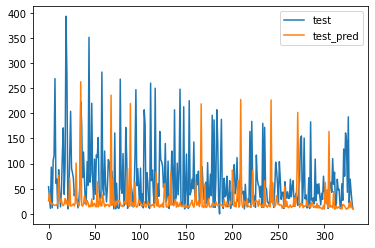


Testing Set Metrics:
Testing MAE: 54.154900903301254
Testing MASE: 0.8865119781895506


In [378]:
test_pred=model_tuned.predict(test.reset_index().rename(columns={'date':'ds', 'log_deaths':'y'})).set_index('ds')
test_pred = test_pred * 0.8
test_pred['yhat'] = np.expm1(test_pred['yhat'])
pd.concat([test.reset_index()['covid_19_deaths'],test_pred.reset_index()['yhat']], axis=1).plot()
plt.legend(['test', 'test_pred'])
plt.show()

test_mae = mean_absolute_error(test['covid_19_deaths'], test_pred['yhat'])
test_mase = MASE(test['covid_19_deaths'], test_pred['yhat'])

print("\nTesting Set Metrics:")
print("Testing MAE:", test_mae)
print("Testing MASE:", test_mase)

In [379]:
# Add holidays
model_tuned = prophet.Prophet(changepoint_prior_scale=0.5, 
                              seasonality_prior_scale=0.01, 
                              holidays_prior_scale = 0.01, 
                              seasonality_mode = 'additive',
                             yearly_seasonality = True, weekly_seasonality = True)

# Add built-in country-specific holidays
model_tuned.add_country_holidays(country_name='US')


for feature in correlated_list:
    model_tuned.add_regressor(feature)

# Fit the model on the training dataset
model_tuned.fit(train.reset_index().rename(columns={'date':'ds', 'log_deaths':'y'}))

16:40:41 - cmdstanpy - INFO - Chain [1] start processing
16:40:52 - cmdstanpy - INFO - Chain [1] done processing


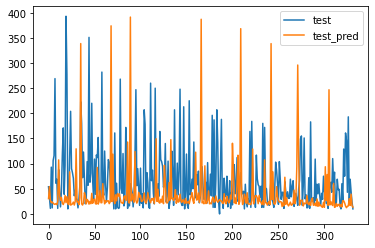


Testing Set Metrics:
Testing MAE: 55.150739104211
Testing MASE: 0.9028137805882216


In [380]:
test_pred=model_tuned.predict(test.reset_index().rename(columns={'date':'ds', 'log_deaths':'y'})).set_index('ds')
test_pred = test_pred * 0.8
test_pred['yhat'] = np.expm1(test_pred['yhat'])
pd.concat([test.reset_index()['covid_19_deaths'],test_pred.reset_index()['yhat']], axis=1).plot()
plt.legend(['test', 'test_pred'])
plt.show()

test_mae = mean_absolute_error(test['covid_19_deaths'], test_pred['yhat'])
test_mase = MASE(test['covid_19_deaths'], test_pred['yhat'])

print("\nTesting Set Metrics:")
print("Testing MAE:", test_mae)
print("Testing MASE:", test_mase)

In [383]:
# Add holidays
model_tuned = prophet.Prophet(changepoint_prior_scale=0.5, 
                              seasonality_prior_scale=0.01, 
                              holidays_prior_scale = 0.01, 
                              seasonality_mode = 'additive', n_changepoints = 3)

# Add built-in country-specific holidays
#model_tuned.add_country_holidays(country_name='US')


for feature in correlated_list:
    model_tuned.add_regressor(feature)
#model_tuned.add_regressor('distributed_janssen')

# Fit the model on the training dataset
model_tuned.fit(train.reset_index().rename(columns={'date':'ds', 'log_deaths':'y'}))

16:41:36 - cmdstanpy - INFO - Chain [1] start processing
16:41:37 - cmdstanpy - INFO - Chain [1] done processing


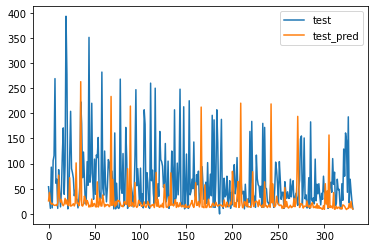


Testing Set Metrics:
Testing MAE: 54.2389482347382
Testing MASE: 0.8878878271858727


In [390]:
test_pred=model_tuned.predict(test.reset_index().rename(columns={'date':'ds', 'log_deaths':'y'})).set_index('ds')
test_pred = test_pred * 0.8
test_pred['yhat'] = np.expm1(test_pred['yhat'])
pd.concat([test.reset_index()['covid_19_deaths'],test_pred.reset_index()['yhat']], axis=1).plot()
plt.legend(['test', 'test_pred'])
plt.show()

test_mae = mean_absolute_error(test['covid_19_deaths'], test_pred['yhat'])
test_mase = MASE(test['covid_19_deaths'], test_pred['yhat'])

print("\nTesting Set Metrics:")
print("Testing MAE:", test_mae)
print("Testing MASE:", test_mase)